<a href="https://colab.research.google.com/github/code3ngon/Graph-Theory/blob/master/Bivariate_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install scikit-posthocs

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro
from scipy.stats import pearsonr, spearmanr

In [3]:
df = pd.read_csv('clean1.csv')
df

,product_type,sku,price,availability,number_of_products_sold,revenue_generated,customer_demographics,stock_levels,lead_times,order_quantities,...,location,lead_time,production_volumes,manufacturing_lead_time,manufacturing_costs,inspection_results,defect_rates,transportation_modes,routes,costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,haircare,SKU95,77.903927,65,672,7386.363944,Unknown,15,14,26,...,Mumbai,18,450,26,58.890686,Pending,1.210882,Air,Route A,778.864241
96,cosmetics,SKU96,24.423131,29,324,7698.424766,Non-binary,67,2,32,...,Mumbai,28,648,28,17.803756,Pending,3.872048,Road,Route A,188.742141
97,haircare,SKU97,3.526111,56,62,4370.916580,Male,46,19,4,...,Mumbai,10,535,13,65.765156,Fail,3.376238,Road,Route A,540.132423
98,skincare,SKU98,19.754605,43,913,8525.952560,Female,53,1,27,...,Chennai,28,581,9,5.604691,Pending,2.908122,Rail,Route A,882.198864


Ai có chi phí thấp nhất

In [4]:
costs_compare = (
    df.groupby('supplier_name')['costs']
      .agg(['mean', 'std', 'count'])
      .reset_index()
      .rename(columns={'mean': 'Mean Cost', 'std': 'Std', 'count': 'n'})
)

# Define z for 95% confidence interval
z = 1.96

costs_compare['CI Lower'] = costs_compare['Mean Cost'] - z * (costs_compare['Std'] / np.sqrt(costs_compare['n']))
costs_compare['CI Upper'] = costs_compare['Mean Cost'] + z * (costs_compare['Std'] / np.sqrt(costs_compare['n']))

costs_compare

,supplier_name,Mean Cost,Std,n,CI Lower,CI Upper
0,Supplier 1,574.851139,266.728699,27,474.240493,675.461784
1,Supplier 2,515.027241,257.192232,22,407.553448,622.501034
2,Supplier 3,468.800102,296.831141,15,318.582818,619.017385
3,Supplier 4,521.810418,269.978457,18,397.086734,646.534102
4,Supplier 5,536.022730,213.727143,18,437.285827,634.759632


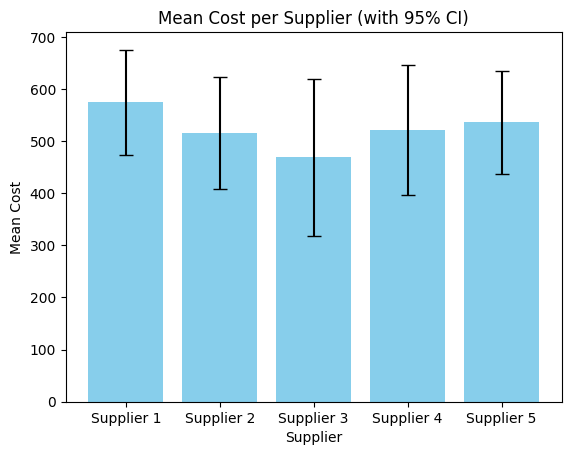

In [5]:
plt.bar(
    costs_compare['supplier_name'],
    costs_compare['Mean Cost'],
    yerr=costs_compare['Mean Cost'] - costs_compare['CI Lower'],
    capsize=5,
    color='skyblue'
)
plt.title('Mean Cost per Supplier (with 95% CI)')
plt.ylabel('Mean Cost')
plt.xlabel('Supplier')
plt.show()


Các khoảng này chồng lấn gần như hoàn toàn.

Không thể khẳng định một supplier nào thật sự rẻ hơn các supplier khác về mặt thống kê, vì sự khác biệt trung bình có thể do ngẫu nhiên trong mẫu.

| Đặc điểm                       | Supplier 3                     |
| ------------------------------ | ------------------------------ |
| Mean thấp nhất (468.8)         | ✅ Có, tốt                      |
| Số mẫu ít nhất (n=15)          | ⚠️ Dữ liệu ít, độ tin cậy thấp |
| Độ lệch chuẩn cao nhất (296.8) | ⚠️ Chi phí biến động mạnh      |
| CI rộng nhất (≈ [319–619])     | ⚠️ Ước lượng kém chính xác     |


⟹ Mặc dù trung bình thấp, Supplier 3 không ổn định và không đủ bằng chứng thống kê để nói rằng rẻ hơn hẳn.

check phân phối

In [6]:
for s in df['supplier_name'].unique():
    data = df[df['supplier_name']==s]['costs']
    stat, p = shapiro(data)
    print(f"{s}: p = {p:.4f}")


Supplier 3: p = 0.1493
Supplier 1: p = 0.0201
Supplier 5: p = 0.4419
Supplier 4: p = 0.1058
Supplier 2: p = 0.6539


| Supplier   | p-value | Kết luận      |
| ---------- | ------- | ------------- |
| Supplier 1 | 0.0201  | ❌ Không chuẩn |
| Supplier 2 | 0.6539  | ✅ Gần chuẩn   |
| Supplier 3 | 0.1493  | ✅ Gần chuẩn   |
| Supplier 4 | 0.1058  | ✅ Gần chuẩn   |
| Supplier 5 | 0.4419  | ✅ Gần chuẩn   |


Kruskal Test

In [7]:
from scipy.stats import kruskal

# Giả sử df là DataFrame gốc
groups = [df[df['supplier_name'] == s]['costs'] for s in df['supplier_name'].unique()]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.4f}")

if p < 0.05:
    print("=> Có sự khác biệt có ý nghĩa thống kê giữa các supplier.")
else:
    print("=> Không có sự khác biệt có ý nghĩa thống kê giữa các supplier.")


Kruskal-Wallis H-statistic = 1.848, p-value = 0.7637
=> Không có sự khác biệt có ý nghĩa thống kê giữa các supplier.


Không có khác biệt lớn về chi phí giữa các supplier → chi phí không phải tiêu chí phân biệt rõ ràng.

Ai mang lại doanh thu cao hơn

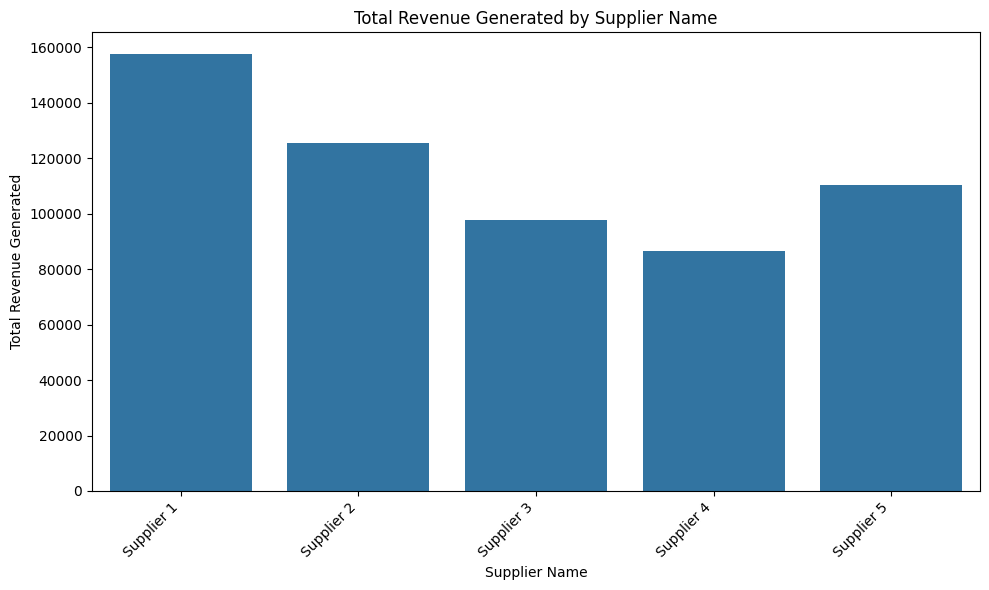

In [8]:
total_revenue_by_supplier = df.groupby('supplier_name')['revenue_generated'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='supplier_name', y='revenue_generated', data=total_revenue_by_supplier)
plt.title('Total Revenue Generated by Supplier Name')
plt.xlabel('Supplier Name')
plt.ylabel('Total Revenue Generated')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Supplier 1 mang lại doanh thu cao nhất

Ai có năng lực sản xuất cao nhất

In [9]:
prod_compare = (
    df.groupby('supplier_name')['production_volumes']
      .agg(['mean', 'std', 'count'])
      .reset_index()
      .rename(columns={'mean': 'Mean', 'std': 'Std', 'count': 'n'})
)

prod_compare['CI Lower'] = prod_compare['Mean'] - z * (prod_compare['Std'] / np.sqrt(prod_compare['n']))
prod_compare['CI Upper'] = prod_compare['Mean'] + z * (prod_compare['Std'] / np.sqrt(prod_compare['n']))

prod_compare


,supplier_name,Mean,Std,n,CI Lower,CI Upper
0,Supplier 1,501.666667,237.248004,27,412.176203,591.157130
1,Supplier 2,641.136364,289.877198,22,520.004392,762.268335
2,Supplier 3,533.133333,227.891536,15,417.804304,648.462363
3,Supplier 4,653.111111,249.197745,18,537.987626,768.234596
4,Supplier 5,521.166667,288.480451,18,387.895498,654.437836


Test phân phối

In [10]:
for s in df['supplier_name'].unique():
    data = df[df['supplier_name']==s]['production_volumes']
    stat, p = shapiro(data)
    print(f"{s}: p = {p:.4f}")


Supplier 3: p = 0.3658
Supplier 1: p = 0.1928
Supplier 5: p = 0.0148
Supplier 4: p = 0.0779
Supplier 2: p = 0.0271


Supplier 1, 3, 4 → p > 0.05 → dữ liệu gần chuẩn

Supplier 2, 5 → p ≤ 0.05 → dữ liệu không chuẩn

⟹ Một số supplier dữ liệu không chuẩn và n không bằng nhau.

Kruskal–Wallis test

In [11]:
from scipy.stats import kruskal
import scikit_posthocs as sp

groups = [df[df['supplier_name']==s]['production_volumes'] for s in df['supplier_name'].unique()]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p:.4f}")

# Nếu p < 0.05
if p < 0.05:
    posthoc = sp.posthoc_dunn(df, val_col='production_volumes', group_col='supplier_name', p_adjust='bonferroni')
    print(posthoc)


Kruskal-Wallis H = 6.186, p = 0.1857


🧠 Diễn giải

Null hypothesis (H0): tất cả các supplier có cùng phân phối production_volumes (năng lực sản xuất).

p = 0.1857 > 0.05 → không bác bỏ H0.

➡️ Nghĩa là: không có bằng chứng thống kê để nói rằng năng lực sản xuất của các supplier khác nhau.

Trung bình (Mean) có thể khác nhau, ví dụ Supplier 4 cao nhất, nhưng sự khác biệt này có thể do ngẫu nhiên.

Vì vậy, không thể khẳng định chắc chắn ai có năng lực sản xuất cao nhất dựa vào dữ liệu hiện tại.

Supplier nào vừa rẻ vừa ít lỗi (tìm điểm cân bằng)

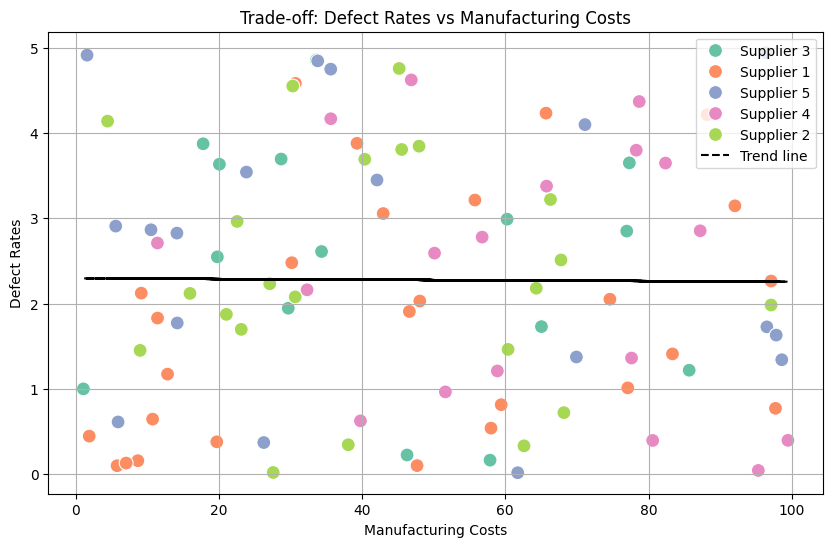

In [12]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df,
    x='manufacturing_costs',
    y='defect_rates',
    hue='supplier_name',
    s=100,
    palette='Set2'
)

# Trend line tổng thể
X = df['manufacturing_costs'].values.reshape(-1,1)
y = df['defect_rates'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
plt.plot(df['manufacturing_costs'], y_pred, color='black', linestyle='--', label='Trend line')

plt.xlabel('Manufacturing Costs')
plt.ylabel('Defect Rates')
plt.title('Trade-off: Defect Rates vs Manufacturing Costs')
plt.legend()
plt.grid(True)
plt.show()


Không có Trade-off.

Có mối quan hệ đánh đổi giữa chi phí và thời gian giao hàng không

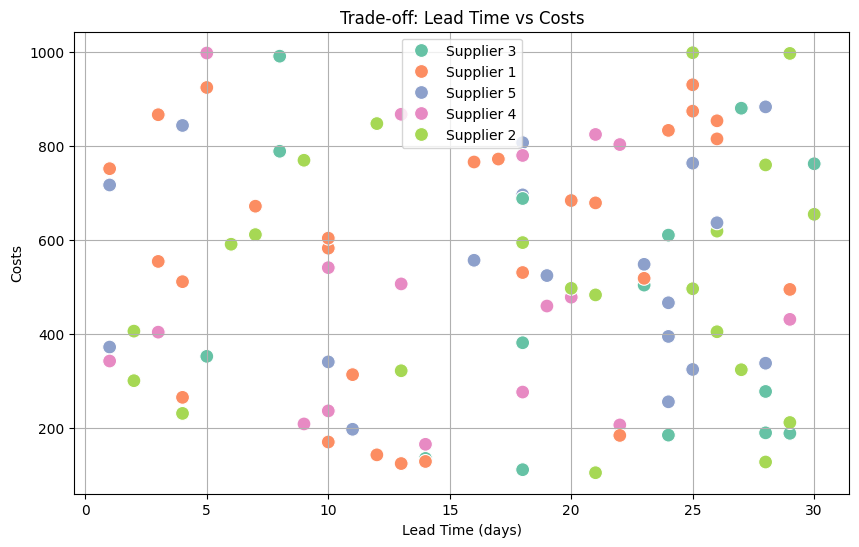

Pearson correlation: 0.045, p-value = 0.6551
Spearman correlation: 0.049, p-value = 0.6303


In [13]:
plt.figure(figsize=(10,6))

# Scatter plot
sns.scatterplot(
    data=df,
    x='lead_time',
    y='costs',
    hue='supplier_name',
    s=100,
    palette='Set2'
)

plt.xlabel('Lead Time (days)')
plt.ylabel('Costs')
plt.title('Trade-off: Lead Time vs Costs')
plt.grid(True)
plt.legend()
plt.show()

# Correlation
# Pearson (linear)
pearson_corr, p_pearson = pearsonr(df['lead_time'], df['costs'])
# Spearman (monotonic)
spearman_corr, p_spearman = spearmanr(df['lead_time'], df['costs'])

print(f"Pearson correlation: {pearson_corr:.3f}, p-value = {p_pearson:.4f}")
print(f"Spearman correlation: {spearman_corr:.3f}, p-value = {p_spearman:.4f}")


🧠 Diễn giải

Cả Pearson và Spearman gần bằng 0 → không có mối quan hệ tuyến tính hay monotonic rõ ràng giữa lead_time và costs.

p-value > 0.05 → không có bằng chứng thống kê cho thấy chi phí tăng/giảm đáng kể theo thời gian giao hàng.

➡️ Nói cách khác:

Dữ liệu hiện tại không cho thấy trade-off rõ ràng giữa chi phí và lead time.

Kiểm tra khả năng đáp ứng đơn hàng của mỗi supplier

In [14]:
summary = df.groupby('supplier_name')['lead_time'].agg(['mean','std','count']).reset_index()
summary['lower'] = summary['mean'] - summary['std']
summary['upper'] = summary['mean'] + summary['std']

summary

,supplier_name,mean,std,count,lower,upper
0,Supplier 1,14.777778,8.550004,27,6.227774,23.327782
1,Supplier 2,18.545455,9.816057,22,8.729397,28.361512
2,Supplier 3,20.133333,8.279637,15,11.853697,28.412970
3,Supplier 4,15.222222,7.922830,18,7.299392,23.145053
4,Supplier 5,18.055556,9.032440,18,9.023116,27.087995


Lựa chọn Tốt nhất: Supplier 4 là lựa chọn tổng thể tốt nhất. Họ kết hợp được cả hai yếu tố: giao hàng nhanh (thứ 2) và ổn định nhất (std thấp nhất).

In [15]:
summary = df.groupby('supplier_name').agg(
    avg_stock=('stock_levels', 'mean'),
    avg_order=('order_quantities', 'mean'),
    std_stock=('stock_levels', 'std'),
    std_order=('order_quantities', 'std'),
    n=('stock_levels', 'count')
).reset_index()

summary


,supplier_name,avg_stock,avg_order,std_stock,std_order,n
0,Supplier 1,42.296296,54.000000,33.025415,25.440731,27
1,Supplier 2,46.454545,46.454545,32.357714,25.902247,22
2,Supplier 3,43.600000,42.133333,28.657584,28.379738,15
3,Supplier 4,58.944444,46.777778,30.305255,29.262615,18
4,Supplier 5,49.888889,53.777778,31.180478,26.847183,18


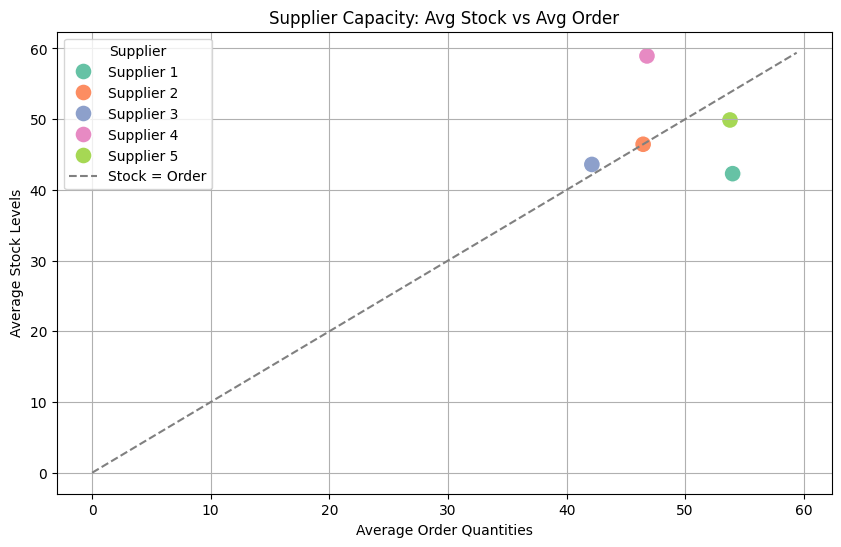

In [16]:
# --------- 2. Scatter plot theo supplier (mean) ---------
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=summary,
    x='avg_order',
    y='avg_stock',
    hue='supplier_name',
    s=150,
    palette='Set2'
)

# Thêm line y=x để trực quan "đủ stock vs thiếu stock"
plt.plot([0, summary['avg_order'].max()*1.1], [0, summary['avg_order'].max()*1.1],
         color='gray', linestyle='--', label='Stock = Order')

plt.xlabel('Average Order Quantities')
plt.ylabel('Average Stock Levels')
plt.title('Supplier Capacity: Avg Stock vs Avg Order')
plt.grid(True)
plt.legend(title='Supplier')
plt.show()


| Supplier       | Nhận xét                                           |
| -------------- | -------------------------------------------------- |
| Supplier 4     | Năng lực đáp ứng **tốt nhất**, dư stock và ổn định |
| Supplier 3     | Đáp ứng vừa đủ, khá ổn định                        |
| Supplier 2     | Đáp ứng vừa đủ, trung bình ổn định                 |
| Supplier 1 & 5 | Có nguy cơ **thiếu stock**, cần theo dõi kỹ        |


Kết loạn: dựa trên Bivaritae Analysis có thể với mục tiêu chọn Supplier thì Supplier 4 có khả năng là nhà cung cấp tót nhứt. Phân tích Bivaritae Analysis chủ yếu dựa trên performance của supplier chưa xét tới các yếu tố product hay manufacturing

